In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split # split  data into training and testing sets
from sklearn.metrics import plot_confusion_matrix # draws a confusion matrix
from sklearn.metrics import classification_report
import xgboost as xgb
from sklearn.feature_selection import VarianceThreshold
import time

In [2]:
root = "../../../../"

In [3]:
df = pd.read_csv(root + "datasets/binary/processed/CICDDoS_pre.csv", index_col=[0])

In [4]:
df[' Label'] = df[' Label'].apply(lambda x: 'ATTACK' if x != 'BENIGN' else 'BENIGN')

In [5]:
encoding = {
    "BENIGN": 0,
    "ATTACK" : 1    
}
decoding = {value:key for key, value in encoding.items()}

In [6]:
df[' Label'] = df[' Label'].map(encoding)

In [7]:
df.head()

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
10431,1,2,0,2736.0,0.0,1368.0,1368.0,1368.0,0.0,0.0,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
13090,1,2,0,2650.0,0.0,1325.0,1325.0,1325.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
12990,2,2,0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,...,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
19624,46,2,0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
20691,1,2,0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [8]:
X = df.drop(columns=[' Label'])
y = df[' Label']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=42, stratify=y)

___
# Remove constant and quasi-constant features based on the training set

In [10]:
selector = VarianceThreshold(threshold=0.01)
selector.fit(X_train)

features_to_keep = X.columns[selector.get_support()]

X_train = selector.transform(X_train)
X_train = pd.DataFrame(X_train)
X_train.columns = features_to_keep

X_test = selector.transform(X_test)
X_test = pd.DataFrame(X_test)
X_test.columns = features_to_keep

___
# Training a model

In [11]:
clf_xgb = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", seed=42)
# clf_xgb.fit(X_train, 
#             y_train,
#             verbose=True,
#             ## the next three arguments set up early stopping.
#             early_stopping_rounds=5,
#             eval_metric='logloss',
#             eval_set=[(X_test, y_test)])
clf_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=42, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

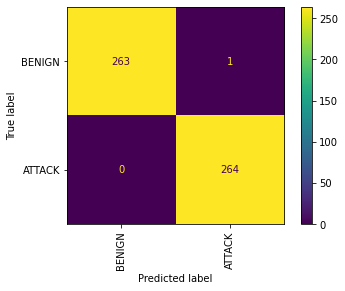

In [12]:
plot_confusion_matrix(clf_xgb, 
                      X_test, 
                      y_test,
                      display_labels=encoding.keys(),
                      values_format='d',
                      xticks_rotation='vertical')
plt.savefig(root + 'pictures/binary/cm_basic.png', bbox_inches='tight')

In [13]:
y_pred = clf_xgb.predict(X_test)

In [14]:
y_pred = pd.Series(y_pred).map(decoding)
y_test = y_test.map(decoding)

In [15]:
print(classification_report(y_test, y_pred, digits=6))

              precision    recall  f1-score   support

      ATTACK   0.996226  1.000000  0.998110       264
      BENIGN   1.000000  0.996212  0.998102       264

    accuracy                       0.998106       528
   macro avg   0.998113  0.998106  0.998106       528
weighted avg   0.998113  0.998106  0.998106       528

